In [13]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
import ProgressMeter

In [14]:
import ReactiveMP.messageout

In [15]:
data_seed, params_seed = 42, 420

(42, 420)

In [16]:
include("../helpers/data.jl")

generate_data

In [17]:
struct DummyDistribution
end

Distributions.entropy(dist::DummyDistribution) = ReactiveMP.InfCountingReal(0.0, -1)

@marginalrule typeof(+)(:in1_in2) (m_out::PointMass, m_in1::NormalDistributionsFamily, m_in2::NormalDistributionsFamily, ) = begin 
    return DummyDistribution()
end


In [18]:
@rule Flow(:in, Marginalisation) (m_out::MultivariateNormalDistributionsFamily, m_in::MultivariateNormalDistributionsFamily, meta::FlowMeta{M,Linearization}) where { M } = begin
    # calculate outgoing message
    message_out = @call_rule Flow(:out, Marginalisation) (m_in=m_in, meta=meta)
    # calculate marginal on output
    marginal_out = prod(ProdAnalytical(), m_out, message_out)
    # propagate marginal through Flow
    marginal_in = @call_rule Flow(:in, Marginalisation) (m_out=marginal_out, meta=meta)
    # calculate upward message
    xi_m_in, W_m_in = weightedmean_precision(m_in)
    xi_q_in, W_q_in = weightedmean_precision(marginal_in)
    # return message
    return MvNormalWeightedMeanPrecision(xi_q_in - xi_m_in, W_q_in - W_m_in)  # maybe add some jitter here for stability
end

In [19]:
function ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ssm (generic function with 1 method)

In [20]:
melu(x) = clamp(x, tiny, Inf)

melu (generic function with 1 method)

In [28]:
order_y, order_u, order_h = 2, 2, 3
full_order = order_h + order_y + order_u
Y = zeros(full_order, order_y); Y[1:order_y, 1:order_y] = diageye(order_y);
U = zeros(full_order, order_u); U[order_y+1:order_y+order_u, 1:order_u] = diageye(order_u);
H = zeros(full_order, order_h); H[full_order-order_h+1:full_order, 1:order_h] = diageye(order_h);

In [29]:
function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [237]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_mv(n, model_flow::FlowModel, model_params, h_prior, y_prev, u, y_order, u_order, h_order)
    
    order = h_order + y_order + u_order
    
    prec = 1e12;
    obs_prec = 1e2
    b = ones(order);
    
    params_flow = model_params[1:end-2]
    params_w    = model_params[end-1:end]
    # initialize variables
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(h_order), prec*diageye(h_order)))}
    w       = randomvar() where {form_constraint = FixedMarginalConstraint(GammaShapeRate(melu(params_w[1]), melu(params_w[2])))}
    h       = randomvar(n)
    hy      = randomvar(n)
    hyu     = randomvar(n)
    y       = datavar(Float64, n)

    y_nodes = Vector{FactorNode}(undef, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    
    Ys = randomvar(n)
    Us = randomvar(n)

    # create meta compile flow model
#     Flow_meta  = FlowMeta(compile(model_flow, params_flow), Unscented(order))
    Flow_meta  = FlowMeta(compile(model_flow, params_flow), Linearization())
    
    AR_meta = ARMeta(Multivariate, h_order, ARsafe())
    
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    w   ~ GammaShapeRate(melu(params_w[1]), melu(params_w[2]))
    θ ~ MvNormalMeanPrecision(zeros(h_order), prec*diageye(h_order))
    
    c = zeros(order_h); c[1] = 1.0;
    
    h_prev = h_0
    for t in 1:n
#         h[t] ~ MvNormalMeanPrecision(S*h_prev, melu(params_w)*c*c' + diageye(order_h+1)*prec)
        
        h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
        # specify latent state
        Ys[t] ~ MvNormalMeanPrecision(Y*y_prev[t], prec*diageye(order))
        Us[t] ~ MvNormalMeanPrecision(U*u[t], prec*diageye(order))
        hy[t] ~ H*h[t] + Ys[t]
        hyu[t] ~ hy[t] + Us[t]
        
#         y_lat_1[t] ~ Flow(hyu[t]) where { meta = Flow_meta, pipeline = RequireInbound(in ) }
        y_lat_1[t] ~ Flow(hyu[t]) where { meta = Flow_meta }
        y_lat_2[t] ~ dot(y_lat_1[t], b)
        
        y_nodes[t], y[t] ~ NormalMeanPrecision(y_lat_2[t], obs_prec)
        h_prev = h[t]
    end

    return h, hy, hyu, y_lat_1, y_lat_2, y, y_nodes, θ, w
end

nonlinear_max_mv (generic function with 1 method)

In [238]:
function nonlinear_max_inference_mv(observations, observations_prev, controls, model_flow::FlowModel, params;  
                                    y_order, u_order, h_order,
                                    h_prior=(zeros(h_order), 0.1*diageye(h_order)), vmp_its=10)
    
    order = h_order + y_order + u_order
    
    # fetch number of samples
    params_w    = params[end-1:end]
    n = length(observations)

    # define model
    model, (h, hy, hyu, y_lat_1, y_lat_2, y, y_nodes, θ, w) = nonlinear_max_mv(n, model_flow, params, h_prior,
                                                                        observations_prev, controls,
                                                                        y_order, u_order, h_order,
                                                                        options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    hy_buffer = Vector{Marginal}(undef, n)
    hyu_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    
    h_sub = subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    hy_sub = subscribe!(getmarginals(hy), (x) -> copyto!(hy_buffer, x))
    hyu_sub = subscribe!(getmarginals(hyu), (x) -> copyto!(hyu_buffer, x))
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginals!(h, MvNormalMeanPrecision(zeros(order_h), diageye(order_h)))
#     setmessages!(h, MvNormalMeanPrecision(randn(order_h), 1e12*diageye(order_h)))
    
    setmarginal!(w, GammaShapeRate(melu(params_w[1]), melu(params_w[2])))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(h_order), 1e12*diageye(h_order)))
    
    ProgressMeter.@showprogress for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, hy_buffer, hyu_buffer, y_out_buffer
    
end

nonlinear_max_inference_mv (generic function with 1 method)

In [239]:
# specify flow model
model_flow = FlowModel(full_order,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

In [240]:
Random.seed!(data_seed)

n_samples = 1000
u = 3 .* sin.(collect(1:n_samples+10))
y_lat, y_obs, h_gen = generate_data(n_samples, narx, Dict(:order_y=>order_y, :order_u=>order_u, :order_e=>order_h),
                                                     Dict(:er_var=>1e-2, :u=>u));

In [241]:
observations_prev, observations = ssm(y_obs, order_y)
controls = ssm(u, order_u)[1]

1008-element Vector{Vector{Float64}}:
 [2.727892280477045, 2.5244129544236893]
 [0.4233600241796016, 2.727892280477045]
 [-2.2704074859237844, 0.4233600241796016]
 [-2.8767728239894153, -2.2704074859237844]
 [-0.8382464945967776, -2.8767728239894153]
 [1.9709597961563672, -0.8382464945967776]
 [2.9680747398701453, 1.9709597961563672]
 [1.2363554557252698, 2.9680747398701453]
 [-1.6320633326681093, 1.2363554557252698]
 [-2.9999706196521103, -1.6320633326681093]
 [-1.609718754001305, -2.9999706196521103]
 [1.2605011104799226, -1.609718754001305]
 [2.971822067084611, 1.2605011104799226]
 ⋮
 [-2.5664194559090623, -2.6939024414938535]
 [-0.07938225821119238, -2.5664194559090623]
 [2.4806386215960075, -0.07938225821119238]
 [2.7599717927589653, 2.4806386215960075]
 [0.5017996259213775, 2.7599717927589653]
 [-2.2177248028207854, 0.5017996259213775]
 [-2.8982832754114494, -2.2177248028207854]
 [-0.9141734707069559, -2.8982832754114494]
 [1.9104232070385518, -0.9141734707069559]
 [2.97858559860

In [242]:
train_size = 800
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size]
X_test, Y_test, U_test = observations_prev[train_size+1:end], observations[train_size+1:end], controls[train_size+1:end];

In [243]:
Random.seed!(params_seed)

flow_param_len = nr_params(model_flow)
flow_params = randn(flow_param_len)
model_params = [flow_params; [1.0, 1.0]]

56-element Vector{Float64}:
 -0.3179695928057278
  0.9776221095017685
 -1.302121139959913
 -0.22534055313176568
  2.2260446301077863
  0.9394246742858201
  1.1017041528684897
  0.7890058448820707
 -0.11671547310971386
  2.643745143350261
  0.9916863399279355
 -2.722437547850197
  0.02618265942906552
  ⋮
 -0.4756875171164519
  0.11870407420280213
  1.2450042382811726
 -0.664937325209685
 -0.11004215429814973
  0.09149482121688793
 -0.29811746891356267
  0.10794398075218822
 -1.1870158605317582
  0.14053187196952818
  1.0
  1.0

In [244]:
fe_, h_, hy_, hyu_, y_out_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, model_params, y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=10);



Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [245]:
fe_

10-element Vector{Any}:
 4841.159520780086
 4841.159520780086
 4841.159520780086
 4841.159520780086
 4841.159520780086
 4841.159520780086
 4841.159520780086
 4841.159520780086
 4841.159520780086
 4841.159520780086

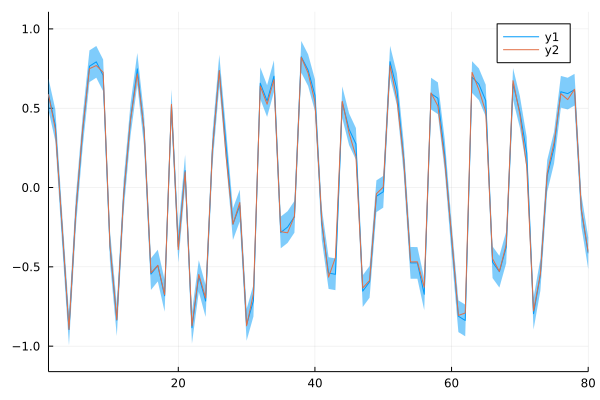

In [246]:
mfrom, mto = 1, 80
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(mfrom, mto))

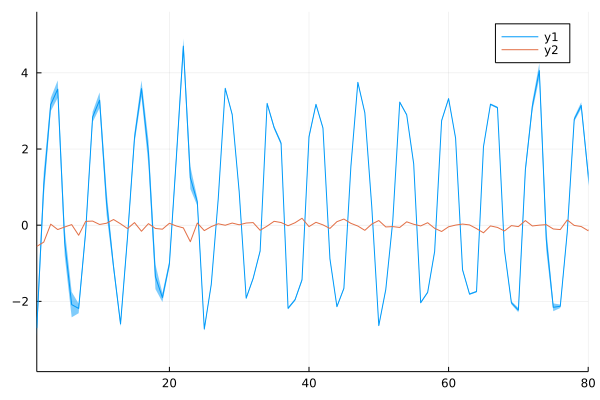

In [247]:
plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))))
plot!(h_gen, xlims=(mfrom, mto))

In [248]:
# Optimization function
function FE(model_params, p=nothing)
    fe_, h_, hy_, hyu_, y_out_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, model_params, y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=2);
    
    return fe_[end]
end;

In [ ]:
using Optim
res = optimize(FE, model_params, GradientDescent(), Optim.Options(g_tol = 1e-8, iterations = 50, store_trace = true, show_trace = true, show_every=1), autodiff=:forward)

Iter     Function value   Gradient norm 
     0     4.857035e+03     1.691940e+03
 * time: 9.799003601074219e-5
     1     4.046251e+03     9.758671e+02
 * time: 103.97418594360352
     2     3.838876e+03     4.165883e+02
 * time: 128.88787293434143
     3     3.004493e+03     1.413790e+03
 * time: 179.7088749408722
     4     2.772024e+03     5.640683e+02
 * time: 239.53289580345154
     5     2.598149e+03     3.934758e+02
 * time: 256.2681498527527
     6     2.506393e+03     2.259996e+02
 * time: 273.5809919834137
     7     2.482533e+03     1.558437e+02
 * time: 290.3806300163269
     8     2.442050e+03     3.095547e+02
 * time: 316.07228088378906
     9     2.428859e+03     1.159652e+02
 * time: 341.0340049266815
    10     2.409689e+03     3.587927e+03
 * time: 376.15083289146423
    11     2.408424e+03     1.463468e+02
 * time: 479.31162190437317


In [999]:
inf_params = Optim.minimizer(res)

47-element Vector{Float64}:
 -0.3158113161430821
  0.9770458910493403
 -1.302447450541252
 -0.22097313971492386
  2.226128587603432
  0.9386339475700755
  1.1055202445563574
  0.7912857764129104
 -0.11639543177462897
  2.645713607943891
  0.9775978733320911
 -2.7293628471855866
  0.012984272384080831
  ⋮
 -0.6872193319062084
  0.06576920476953409
  0.09405377251697167
  0.0893089742803576
 -1.0451017922962045
 -0.5308360426126556
 -0.14984976127154748
  0.05887204439803716
 -1.3598004788501439
 -0.4758284105013746
  0.9999446186409431
  1.000055381359078

In [1000]:
fe_, h_, hy_, hyu_, y_out_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, inf_params, y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=40);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


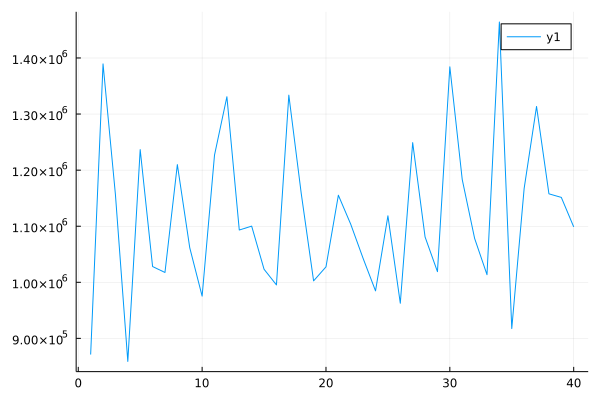

In [1001]:
plot(fe_)

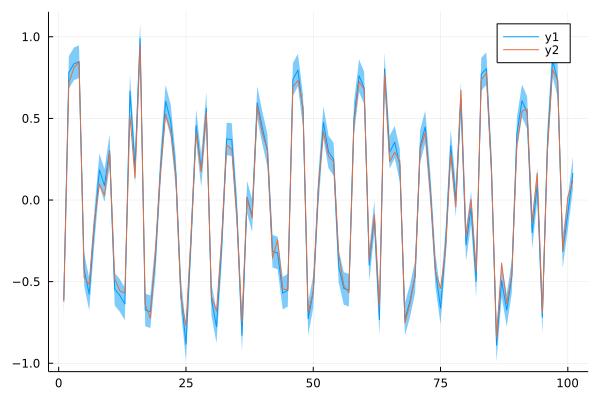

In [1002]:
mfrom, mto = 100, 200
plot(mean.(y_out_[mfrom:mto]), ribbon=sqrt.(cov.(y_out_[mfrom:mto])))
plot!(Y_train[mfrom:mto])

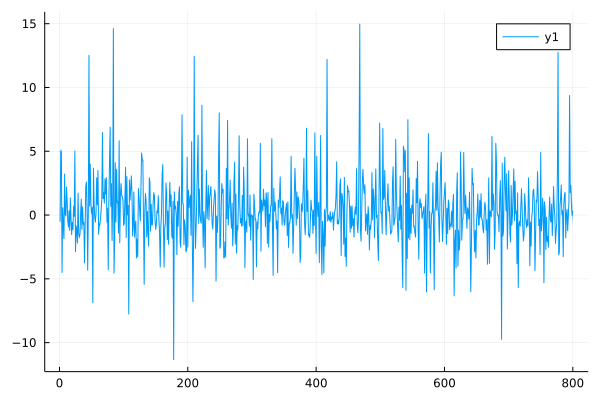

In [1003]:
plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))))

In [1004]:
cov.(h_)

800-element Vector{Matrix{Float64}}:
 [0.021057721055343773 -0.007850375961645586 0.005422207851027154; -0.007850375961645586 0.026983236513482375 -0.018637160511081774; 0.005422207851027154 -0.018637160511081774 0.0491277745304811]
 [0.020876443354488627 -0.004683478766859135 0.0011331741383314722; -0.004683478766859135 0.020272481861448224 -0.004904954908249277; 0.0011331741383314722 -0.004904954908249277 0.025862649677427244]
 [0.030838246147688063 -0.004765008625354595 0.001538870282870042; -0.004765008625354595 0.01895406213315622 -0.006121257116132901; 0.001538870282870042 -0.006121257116132901 0.038101850866688526]
 [0.03140469530836204 -0.0042333549229182955 0.0010652645801546294; -0.0042333549229182955 0.016294698202668628 -0.004100332987824751; 0.0010652645801546294 -0.004100332987824751 0.021708285019532765]
 [0.021088847663802344 -0.007468101660477436 0.00010549423932816569; -0.007468101660477436 0.030202863124775294 -0.00042664497830057375; 0.00010549423932816569 -0.000426

## KF-like prediction

In [1005]:
function transition(γ, order)
    V = zeros(order, order)
#     V = 1e-12*diageye(order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [1006]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction_mv_model(model_flow::FlowModel, params, h_prior, w, y_prev, u, full_order)
    
    h_order = length(h_prior[1])

    A = shift(h_order) # transition matrix
    V = transition(w, h_order)
    c = zeros(h_order); c[1] = 1.0

    # initialize variables
    y_pred   = datavar(Float64)
    
    Ys = Y*y_prev
    Us = U*u
    
    h_0 = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(h_prior[1], h_prior[2]))}

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, inf_params[1:end-2])) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    
    Ah ~ A*h_0
    h ~ MvNormalMeanCovariance(Ah, V) where {q = q(Ah, h)q(V)}

    hy ~ H*h + Ys
    hyu ~ hy + Us
    
    y_lat_1 ~ Flow(hyu) where { meta = Flow_meta, q = FullFactorisation() }
    
    y_lat_2 ~ dot(y_lat_1, ones(full_order))

    y_node, y ~ NormalMeanPrecision(y_lat_2 + dot(h, c), 1e4)
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred
end

nonlinear_max_prediction_mv_model (generic function with 1 method)

In [1007]:
function nonlinear_max_prediction_mv(observation_prev, control, model_flow::FlowModel, params; full_order, 
                                     h_prior=(ones(2), diageye(2)), w=1.0, vmp_its = 50)

    # define model
    model, (h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred) = nonlinear_max_prediction_mv_model(model_flow, params, h_prior, w,
                                                                                             observation_prev, control, full_order,
                                                                                             options = (limit_stack_depth = 500, ))
    
    h_order = length(h_prior[1])
    
    h_buffer = nothing
    h0_buffer = nothing
    y_out_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    h0_sub = subscribe!(getmarginal(h_0), (x) -> h0_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y_lat_2), (x) -> y_pred_buffer = x)

    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    setmessage!(h, MvNormalMeanPrecision(h_prior[1], h_prior[2]))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, h0_buffer, y_pred_buffer
    
end

nonlinear_max_prediction_mv (generic function with 1 method)

In [1008]:
mean(h_[end])

3-element Vector{Float64}:
  0.30967875263622846
 -0.5162134104714245
 -2.6028280272269213

In [1009]:
predictions = []
h_prev = (mean(h_[end]), precision(h_[end]))
ŵ = inf_params[end-1:end][1]/inf_params[end-1:end][2]
for i in 1:length(X_test)
    fe, h, h_0, y_pred = nonlinear_max_prediction_mv(X_test[i], U_test[i], model_flow, inf_params, full_order=full_order, h_prior=h_prev, w=ŵ, vmp_its=1)
    push!(predictions, y_pred)
    _, h_inf, _, _, _ = nonlinear_max_inference_mv([Y_test[i]], [X_test[i]], [U_test[i]], model_flow, inf_params, y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=10);
    h_prev = (mean.(h_inf)[end], precision.(h_inf)[end])
    
end

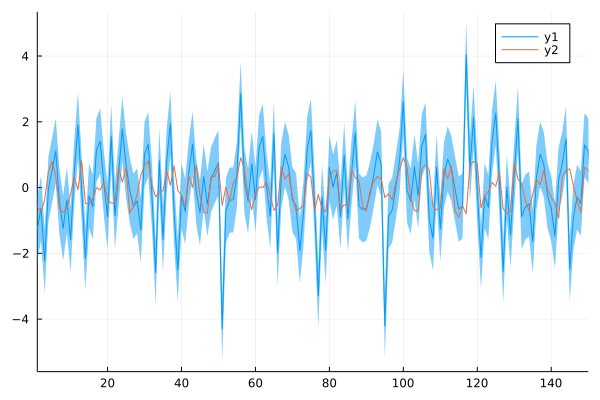

In [1010]:
plot(mean.(predictions), ribbon=sqrt.(first.(cov.(predictions))))
plot!(Y_test, xlims=(1, 150))